In [18]:
import numpy as np
import cv2
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [19]:
# Unzip the pre-uploaded file
zip_path = '/content/animals.zip'
extract_dir = '/content/animals'
if not os.path.exists(extract_dir):
    print("Unzipping animals.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content')
    print("Unzipping completed")
else:
    print("Dataset already unzipped")

# Verify unzipped folder and subfolders
data_dir = extract_dir
print("Contents of /content:", os.listdir('/content'))
print("Files in unzipped directory:", os.listdir(data_dir))

# Check subfolder contents
for class_name in ['dog', 'cat']:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.exists(class_dir):
        files_in_dir = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
        print(f"Files in {class_name} subfolder: {files_in_dir[:5]}")  # Show first 5 files
    else:
        print(f"Subfolder {class_name} not found in {data_dir}")

Dataset already unzipped
Contents of /content: ['.config', '.ipynb_checkpoints', 'animals', 'animals.zip', 'sample_data']
Files in unzipped directory: ['cat', 'dog']
Files in dog subfolder: ['00614-3846168776.png', '00718-3846168880.png', '00537-3846168699.png', '00684-3846168846.png', '00623-3846168785.png']
Files in cat subfolder: ['00075-200124385.png', '00141-200124451.png', '00151-200124461.png', '00038-200124348.png', '00182-200124492.png']


In [20]:
# Parameters
IMG_SIZE = 64  # Resize images to 64x64

# Initialize lists
images = []
labels = []
failed_images = []

# Load images from dog and cat subfolders
for label, class_name in enumerate(['cat', 'dog']):
    class_dir = os.path.join(data_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: {class_dir} does not exist. Skipping...")
        continue
    count = 0
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Support .jpg, .jpeg, and .png
            img_path = os.path.join(class_dir, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img.flatten())  # Flatten to 1D vector
                    labels.append(label)  # 0=cat, 1=dog
                    count += 1
                else:
                    failed_images.append(img_path)
                    print(f"Failed to load {img_path}")
            except Exception as e:
                failed_images.append(img_path)
                print(f"Error loading {img_path}: {e}")
    print(f"Loaded {count} images from {class_name} folder")

# Convert to arrays
X = np.array(images)
y = np.array(labels)

if len(X) == 0:
    raise ValueError(f"No images were loaded. Check file paths or image formats. Failed images: {failed_images}")
print("Dataset shape:", X.shape, y.shape)

Loaded 283 images from cat folder
Loaded 283 images from dog folder
Dataset shape: (566, 4096) (566,)


In [21]:
# Split data: 80% train, 20% test with validation
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
else:
    raise ValueError("No data to split. Check previous steps.")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape, y_train.shape)
print("Testing set shape:", X_test_scaled.shape, y_test.shape)

Training set shape: (452, 4096) (452,)
Testing set shape: (114, 4096) (114,)



Test Accuracy: 0.8246

Classification Report:
              precision    recall  f1-score   support

         Cat       0.82      0.82      0.82        57
         Dog       0.82      0.82      0.82        57

    accuracy                           0.82       114
   macro avg       0.82      0.82      0.82       114
weighted avg       0.82      0.82      0.82       114



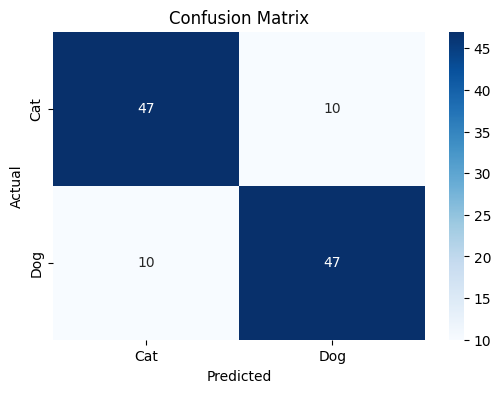

In [22]:
# Initialize and train SVM
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = svm.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

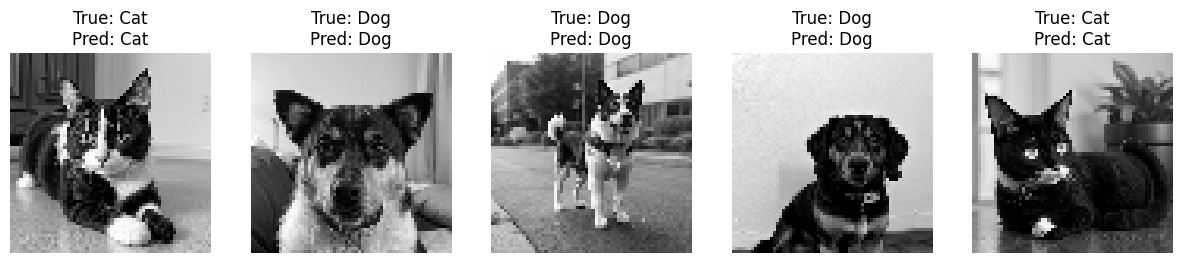

In [23]:
# Visualize up to 5 sample test images with predictions
sample_size = min(5, len(X_test))
if sample_size > 0:
    sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx].reshape(IMG_SIZE, IMG_SIZE)
        true_label = 'Cat' if y_test[idx] == 0 else 'Dog'
        pred_label = 'Cat' if y_pred[idx] == 0 else 'Dog'
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()
else:
    print("Not enough test samples to visualize.")

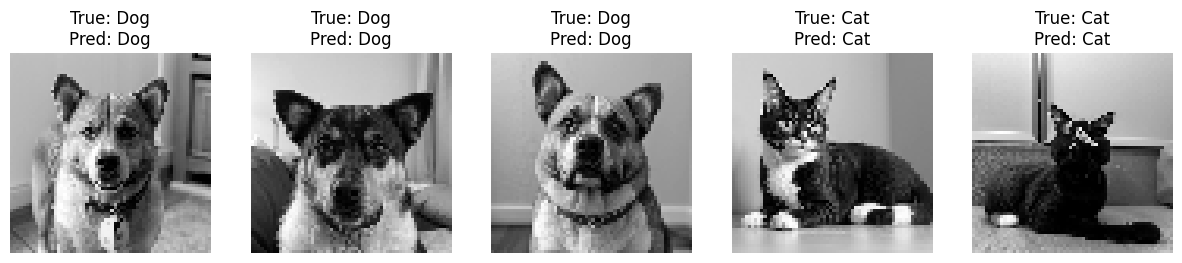

In [24]:
# Visualize up to 5 sample test images with predictions
sample_size = min(5, len(X_test))
if sample_size > 0:
    sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(sample_indices):
        img = X_test[idx].reshape(IMG_SIZE, IMG_SIZE)
        true_label = 'Cat' if y_test[idx] == 0 else 'Dog'
        pred_label = 'Cat' if y_pred[idx] == 0 else 'Dog'
        plt.subplot(1, sample_size, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.show()
else:
    print("Not enough test samples to visualize.")

Please upload an image (jpg, jpeg, or png format) of a cat or dog


Saving dog2.jpg to dog2 (1).jpg


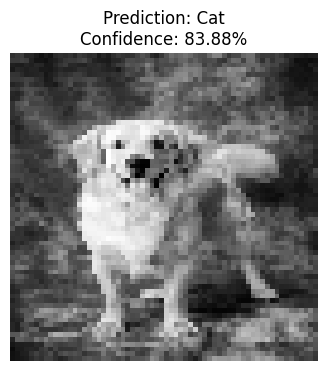


The image is predicted to be a Cat with 83.88% confidence


In [29]:
# Function to preprocess user-uploaded image
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Could not load image")
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_flat = img.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    return img, img_scaled

# Upload and predict
print("Please upload an image (jpg, jpeg, or png format) of a cat or dog")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Process and predict
img, img_scaled = preprocess_image(img_path)
pred = svm.predict(img_scaled)[0]
prob = svm.predict_proba(img_scaled)[0]
label = 'Cat' if pred == 0 else 'Dog'
confidence = prob[pred] * 100

# Display result
plt.figure(figsize=(4, 4))
plt.imshow(img, cmap='gray')
plt.title(f"Prediction: {label}\nConfidence: {confidence:.2f}%")
plt.axis('off')
plt.show()
print(f"\nThe image is predicted to be a {label} with {confidence:.2f}% confidence")